In [1]:
import pandas as pd
from datasets import load_dataset
import json
import random

/users/ansaripo/miniconda3/envs/robots/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
par_data = '/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/data/output'
data = load_dataset("parquet", data_dir=par_data)['train']
data = data.shuffle()
data12800 = data.select(range(12800))
data1000 = data.select(range(1000))
with open("/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/12800_news_23_24.jsonl", "w") as f:
    for data_ in data12800:
        f.write(json.dumps(data_) + "\n")

with open("/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/1000_news_23_24.jsonl", "w") as f:
    for data_ in data1000:
        f.write(json.dumps(data_) + "\n")


In [13]:
folder_path = "/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/12800_news_23_24.jsonl"

data = []
with open(folder_path, "r") as f:
    for line in f:
        tmp = json.loads(line)
        if len(tmp['text']) > 512:
            data.append(tmp)

data1000_mcq = data[:1000]

with open("/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/1000_mcq_news_23_24.jsonl", "w") as f:
    for data_ in data1000_mcq:
        f.write(json.dumps(data_) + "\n")

data1000_mcm = data[1000:2000]

with open("/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/1000_mcm_news_23_24.jsonl", "w") as f:
    for data_ in data1000_mcm:
        f.write(json.dumps(data_) + "\n")


In [27]:
from datasets import Dataset
import os

folder_path = "/iopsstor/scratch/cscs/ansaripo/robots_txt_allnews_contamination-50gram_5/swissai-fineweb-edu-news2324/12800_news_23_24.jsonl"

# Set the folder containing the .txt files
pre_len = 128
dataset_name = f"news_2023_2024_verbatim_{pre_len}"

# Read text files into a list of dicts
data = []
# for filename in os.listdir(folder_path):
#     if filename.endswith(".txt"):
#         with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
#             data.append({"filename": filename, "text": f.read()})
with open(folder_path, "r") as f:
    for line in f:
        data.append(json.loads(line))
# Create a Hugging Face Dataset
dataset = Dataset.from_list(data)



<Axes: >

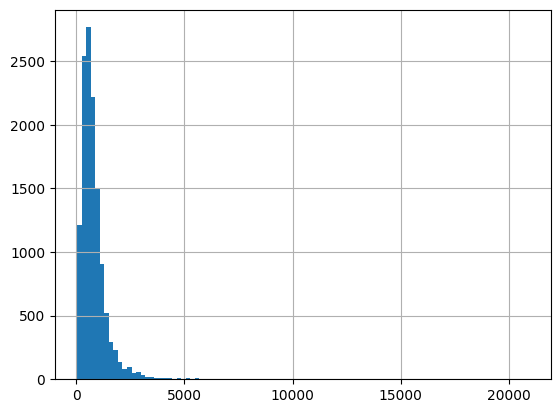

In [28]:
dataset.to_pandas()['text'].apply(lambda x: len(x.split())).hist(bins=100)

In [29]:
from transformers import AutoTokenizer
# get the first 20000 examples
# fset = dataset["train"].select(range(12800))
fset = dataset
tokenizer = AutoTokenizer.from_pretrained('alehc/swissai-tokenizer')

In [30]:
# from transformers import AutoTokenizer
# # get the first 20000 examples
# subset = dataset["train"].select(range(12800))
# tokenizer = AutoTokenizer.from_pretrained('alehc/swissai-tokenizer')

def split_example(examples, input_size=pre_len, max_tokens=4096):
    # text = example['text']
    # tokens = tokenizer.tokenize(text)
    # input = tokenizer.convert_tokens_to_string(tokens[:input_size])
    # target = tokenizer.convert_tokens_to_string(tokens[input_size:max_tokens])
    # return {'input_text': input, 'target_text': target}
    input_texts = []
    target_texts = []
    
    for i, text in enumerate(examples['text']):
        tokens = tokenizer.tokenize(text)
        input = tokenizer.convert_tokens_to_string(tokens[:input_size])
        target = tokenizer.convert_tokens_to_string(tokens[input_size:max_tokens])
        input_texts.append(input)
        target_texts.append(target)
    
    return {'input_text': input_texts, 'target_text': target_texts}

subset = fset.map(split_example, batched=True)


Map: 100%|██████████| 12800/12800 [00:29<00:00, 427.22 examples/s]


In [31]:
positive_examples = subset.filter(lambda example: len(example['target_text']) != 0)

Filter: 100%|██████████| 12800/12800 [00:00<00:00, 48227.67 examples/s]


In [ ]:
# push the dataset to the hub
from datasets import Dataset, DatasetDict

HF_TOKEN=''
from huggingface_hub import login
login(HF_TOKEN)
DatasetDict({'test': positive_examples}).push_to_hub(dataset_name)

Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/mansaripo/news_2023_2024_verbatim_128/commit/774f159892ad1deea8967b66152414ece514a66a', commit_message='Upload dataset', commit_description='', oid='774f159892ad1deea8967b66152414ece514a66a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mansaripo/news_2023_2024_verbatim_128', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mansaripo/news_2023_2024_verbatim_128'), pr_revision=None, pr_num=None)